# Airlines Dataset: Divergence Applications

In this example, we will demonstrate change point detection and clustering on the public Airlines data set.

In [1]:
import pandas
pandas.options.display.max_rows=5 # restrict to 5 rows on display

df = pandas.read_csv("https://raw.githubusercontent.com/Devvrat53/Flight-Delay-Prediction/master/Data/flight_data.csv")
df['date'] = pandas.to_datetime(df[['year', 'month', 'day']])
df['day_index'] = (df['date'] - df['date'].min()).dt.days
df['DayOfWeek'] = df['date'].dt.day_name()
df['Month'] = df['date'].dt.month_name()
df

year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0       2013      1    1     517.0             515        2.0     830.0   
1       2013      1    1     533.0             529        4.0     850.0   
...      ...    ...  ...       ...             ...        ...       ...   
336774  2013      9   30       NaN            1159        NaN       NaN   
336775  2013      9   30       NaN             840        NaN       NaN   

        sched_arr_time  arr_delay carrier  ...  dest air_time distance hour  \
0                  819       11.0      UA  ...   IAH    227.0     1400    5   
1                  830       20.0      UA  ...   IAH    227.0     1416    5   
...                ...        ...     ...  ...   ...      ...      ...  ...   
336774            1344        NaN      MQ  ...   CLE      NaN      419   11   
336775            1020        NaN      MQ  ...   RDU      NaN      431    8   

        minute         time_hour       date  day_index DayOfWeek      Month  
0           15     1/1/2013 5:00 2013-01-01          0   Tuesday    January  
1           29     1/1/2013 5:00 2013-01-01          0   Tuesday    January  
...        ...               ...        ...        ...       ...        ...  
336774      59  30-09-2013 11:00 2013-09-30        272    Monday  September  
336775      40  30-09-2013 08:00 2013-09-30        272    Monday  September  

[336776 rows x 23 columns]

## Destination Airport

Let's just look at how the `dest` feature changes from month to month. In this example, we will use total variation. Since `dest` is a categorical variable, it is natural to use a density estimator based approach to calculating statistical divergences such as total variation. We use the `calc_tv_mle` function for this, which computes maximum likelihood based density estimators using histograms, and subsequently feeds this into the formula for [total variation](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures).

In [2]:
import numpy

from mvtk.supervisor.divergence import calc_tv_mle

covariate = ['dest']
max_likelihood_drift_series = []
def encode(v, d={}):
    if not v in d:
        d[v] = len(d)
    return d[v]
grouped = df.groupby('Month')
batches = [g[1][covariate].values.reshape(-1, 1) for g in grouped]
max_likelihood_drift_series = []
for (month, _), new_batch, old_batch in zip(grouped, batches[1:], batches[:-1]):
    max_likelihood_drift_series.append(calc_tv_mle([old_batch], [new_batch]))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/

Using Python version 3.8.11 (default, Aug  6 2021 08:56:27)
Spark context Web UI available at http://c02yn2epjg5j.corp.root.nasd.com:4040
Spark context available as 'sc' (master = local[*], app id = local-1630586243406).
SparkSession available as 'spark'.


In [3]:
df[covariate].nunique()

dest    105
dtype: int64

## Density vs Variational

Now let's compare these results to those produced by variational estimators. Variational estimation of statistical divergences is an elegant approach well suited for high dimensional floating point data. However, categorical data needs to be one hot encoded to be made compatible with the variational approach. Since `dest` has 105 unique values, this requires turning a one dimensional dataset into a 105 dimensional one. We can increase the batch size and number of epochs to try to compensate for this. As we shall see, this makes the problem complex enough that the variational estimates do not agree well with the histogram based ones.

In [4]:
from sklearn.preprocessing import OneHotEncoder
from mvtk.supervisor.divergence import calc_tv

covariate = ['dest']

encoder = OneHotEncoder(sparse=False)
encoder.fit(df[covariate].values)

variational_drift_series = []
previous_ohc = None
months = []
for i, (month, group1) in enumerate(df.groupby('Month')):
    ohc = [encoder.transform(group1[covariate])]
    if previous_ohc is not None:
        variational_drift_series.append(calc_tv(ohc, previous_ohc, num_epochs=16, num_batches=32, batch_size=512))
        months.append(month)
    previous_ohc = ohc

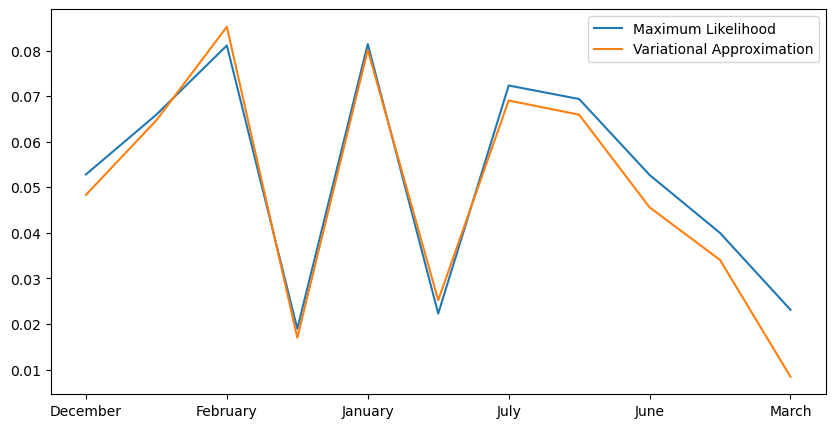

In [5]:
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()

plt.plot(max_likelihood_drift_series, label='Maximum Likelihood')
plt.plot(variational_drift_series, label='Variational Approximation')

ax.xaxis.set_major_formatter(lambda x_val, x_pos: months[int(x_pos)])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

Generally, the variational estimator degrades in accuracy for categorical data with large numbers of categories. However, it works quite well for this example after increasing the batch size and number of epochs for more accurate estimates.

In [6]:
numpy.corrcoef(variational_drift_series, max_likelihood_drift_series)[1, 0]

0.9831698719629802

## Clustering

Now let's construct a distance matrix between data aggregated by each day of the week and cluster it.

0it [00:00, ?it/s]

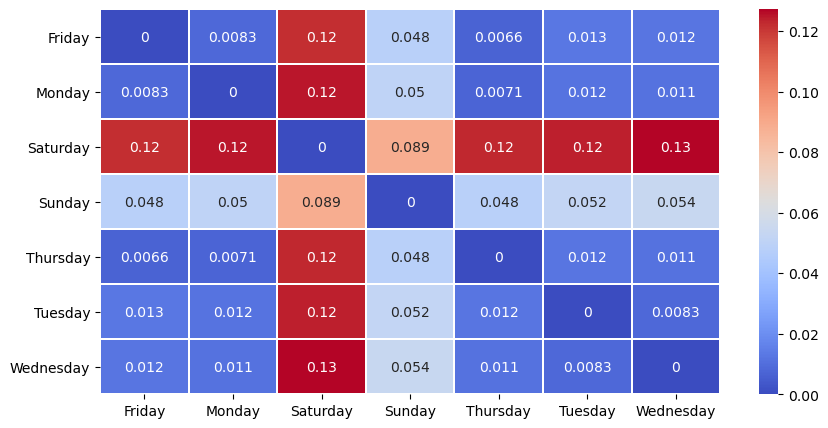

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy

from mvtk.supervisor.divergence import calc_tv_mle
from mvtk.supervisor.divergence import get_distance_matrix
from mvtk.supervisor.utils import parallel
from mvtk.supervisor.utils import compute_divergence_crosstabs

feature_names = ['origin', 'dest']
features = df[feature_names + ['DayOfWeek']]
distance_matrix = compute_divergence_crosstabs(features,
                                               'DayOfWeek',
                                               divergence=calc_tv_mle)
sns.heatmap(distance_matrix, cmap='coolwarm', linewidths=0.30, annot=True)
plt.show()

As we might expect, it seems Saturday, and to a lesser extent Sunday, are somewhat different from the other days of the week.

In [8]:
from sklearn.cluster import AgglomerativeClustering

def agglomerative_clustering(distance_matrix, n_clusters, affinity='precomputed', linkage='complete', **kwargs):
    return AgglomerativeClustering(n_clusters=n_clusters, **kwargs).fit_predict(distance_matrix)

print('Two clusters', agglomerative_clustering(distance_matrix, n_clusters=2, linkage='complete'))
print('Three clusters', agglomerative_clustering(distance_matrix, n_clusters=3, linkage='complete'))

Two clusters [0 0 1 0 0 0 0]
Three clusters [0 0 1 2 0 0 0]


/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## More data

In [9]:
import os
import pandas

df = df[['origin', 'dest', 'day_index']]

In [10]:
import itertools
import numpy

from mvtk.supervisor.divergence import calc_tv_mle

df.sort_values('day_index', inplace=True)
features = df[feature_names + ['day_index']]
distance_matrix = compute_divergence_crosstabs(features, 'day_index', divergence=calc_tv_mle)

/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0it [00:00, ?it/s]

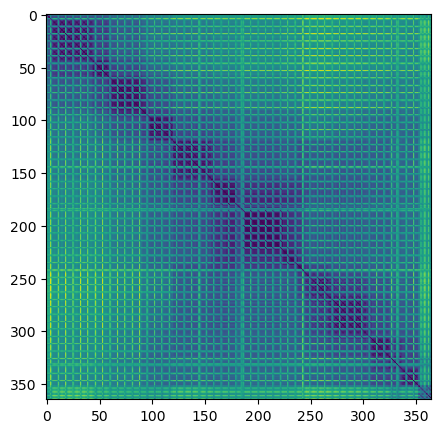

In [11]:
import matplotlib.pyplot as plt

plt.imshow(distance_matrix)
plt.show()